In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

# from IPython import display

plt.style.use(['dark_background'])
%matplotlib inline

class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()

        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)   
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)

class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            random.randrange(self.num_actions)
            return torch.tensor(random.randrange(self.num_actions)) # explore   
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device)

class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
        
    def reset(self):
        self.env.reset()
        self.current_screen = None

    def close(self):
        self.env.close()

    def render(self, mode='human'):
        return self.env.render(mode)
    def num_actions_available(self):
        return self.env.action_space.n
    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    def just_starting(self):
        return self.current_screen is None
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    def crop_screen(self, screen):
        screen_height = screen.shape[1]

        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)

        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])

        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)


def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode moving avg:", moving_avg[-1])
    # print(moving_avg.max(),np.argmax(moving_avg))
    if is_ipython: display.clear_output(wait=True)

def plot2(values, moving_avg_period,steps_list):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(steps_list,values)

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(steps_list,moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)
        
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)


In [ ]:
import os
import pickle
import time

In [ ]:
# a = get_moving_average(100,episode_durations)
# print(a.max(),np.argmax(a))

# Test:

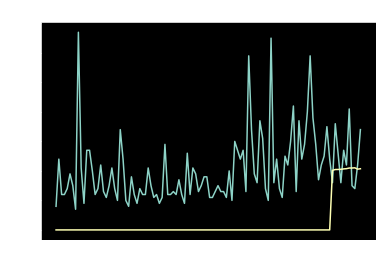

Episode 110 
 100 episode moving avg: 20.73


In [ ]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod        
    def get_next(target_net, next_states, policy_net):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        
        am = policy_net(non_final_states).max(dim=1)[1] #argmaxes!
        qs = target_net(non_final_states)
        
        values[non_final_state_locations] = qs.gather(1, am.reshape(len(am),1)).reshape(len(qs)).detach()
        return values

batch_size = 256
gamma = 0.99
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
target_update2 = 5
memory_size = 100000
lr = 0.001
num_episodes = 110

em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_durations = []

for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    for timestep in count():
        action = (agent.select_action(state, policy_net)).reshape(1).cuda()
        reward = em.take_action(action)
        next_state = em.get_state()
#         print(action)
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states, policy_net)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
em.close()

In [ ]:
# moving_avg = get_moving_average(100, episode_durations)
# print('best duration obtained: ',moving_avg.max(),'\nat episode: ', np.argmax(moving_avg))

best duration obtained:  21.05 
at episode:  107


# DDQN:

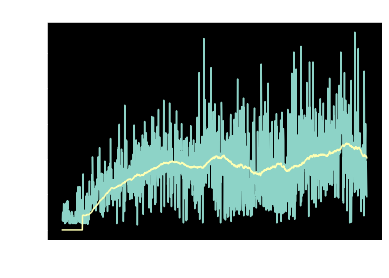

Episode 1500 
 100 episode moving avg: 101.76


In [ ]:
t1 = time.time()
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod        
    def get_next(target_net, next_states, policy_net):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        
        am = policy_net(non_final_states).max(dim=1)[1] #argmaxes!
        qs = target_net(non_final_states)
        
        values[non_final_state_locations] = qs.gather(1, am.reshape(len(am),1)).reshape(len(qs)).detach()
        return values

batch_size = 256
gamma = 0.99
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
target_update2 = 5
memory_size = 50000
lr = 0.001
num_episodes = 1500

em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_durations_ddqn = []

for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    for timestep in count():
        action = (agent.select_action(state, policy_net)).reshape(1).cuda()
        reward = em.take_action(action)
        next_state = em.get_state()
#         print(action)
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states, policy_net)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if em.done:
            episode_durations_ddqn.append(timestep)
            plot(episode_durations_ddqn, 100)
            break
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
em.close()
t2 = time.time()

In [ ]:
moving_avg_ddqn = get_moving_average(100, episode_durations_ddqn)
print('best duration obtained: ',moving_avg_ddqn.max(),'\nat episode: ', np.argmax(moving_avg_ddqn))

best duration obtained:  122.4 
at episode:  1399


In [ ]:
ex_ddqn = t2-t1
path_ddqn = '/content/drive/MyDrive/DRL/Cart/ddqn_scalars.pkl'
obj_ddqn = [episode_durations_ddqn,moving_avg_ddqn,ex_ddqn]
f = open(path_ddqn, 'wb')
pickle.dump(obj_ddqn, f)
f.close()

In [ ]:
print(ex_ddqn)

# TDQN:

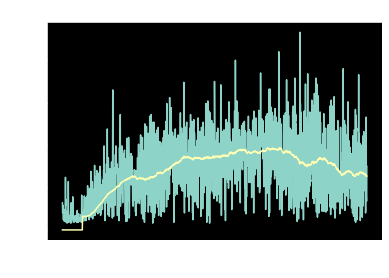

Episode 1500 
 100 episode moving avg: 63.49


In [ ]:
t1 = time.time()
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod        
    def get_next(target_net, next_states, policy_net):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        
        am = policy_net(non_final_states).max(dim=1)[1] #argmaxes!
        qs = target_net(non_final_states)
        
        values[non_final_state_locations] = qs.gather(1, am.reshape(len(am),1)).reshape(len(qs)).detach()
        return values

batch_size = 256
gamma = 0.99
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
target_update2 = 5
memory_size = 50000
lr = 0.001
num_episodes = 1500

em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net2 = DQN(em.get_screen_height(), em.get_screen_width()).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

target_net2.load_state_dict(policy_net.state_dict())
target_net2.eval()

optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_durations_tdqn = []

for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    for timestep in count():
        action = (agent.select_action(state, policy_net)).reshape(1).cuda()
        reward = em.take_action(action)
        next_state = em.get_state()
#         print(action)
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states, target_net2)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if em.done:
            episode_durations_tdqn.append(timestep)
            plot(episode_durations_tdqn, 100)
            break
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
    if episode % target_update2 == 0:
        target_net2.load_state_dict(policy_net.state_dict())
em.close()
t2 = time.time()

In [ ]:
moving_avg_tdqn = get_moving_average(100, episode_durations_tdqn)
print('best duration obtained: ',moving_avg_tdqn.max(),'\nat episode: ', np.argmax(moving_avg_tdqn))

best duration obtained:  96.76 
at episode:  1074


In [ ]:
ex_tdqn = t2-t1
path = '/content/drive/MyDrive/DRL/Cart/tdqn_scalars.pkl'
obj_tdqn = [episode_durations_tdqn,moving_avg_tdqn,ex_tdqn]
f = open(path, 'wb')
pickle.dump(obj_tdqn, f)
f.close()

In [ ]:
print(ex_tdqn)

1318.85120677948


# Semi-Decoupled:

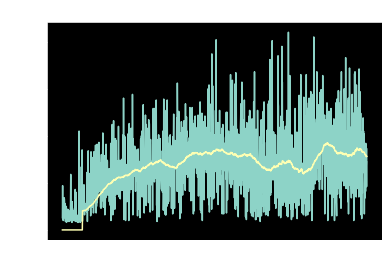

Episode 1500 
 100 episode moving avg: 78.14


In [ ]:
t1 = time.time()
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy1, states, actions):
        return policy1(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod        
    def get_next(target1, next_states, target2):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        
        am = target1(non_final_states).max(dim=1)[1] #argmaxes!
        qs = target2(non_final_states)
        
        values[non_final_state_locations] = qs.gather(1, am.reshape(len(am),1)).reshape(len(qs)).detach()
        return values

batch_size = 256
gamma = 0.99
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update1 = 10
target_update2 = 10
memory_size = 50000
lr = 0.001
num_episodes = 1500

em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy1 = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
policy2 = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target1 = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target2 = DQN(em.get_screen_height(), em.get_screen_width()).to(device)

target1.load_state_dict(policy1.state_dict())
target1.eval()

target2.load_state_dict(policy2.state_dict())
target2.eval()


optimizer1 = optim.Adam(params=policy1.parameters(), lr=lr)
optimizer2 = optim.Adam(params=policy2.parameters(), lr=lr)


episode_durations_sd = []

for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    for timestep in count():
        action = (agent.select_action(state, policy1)).reshape(1).cuda()
        reward = em.take_action(action)
        next_state = em.get_state()
#         print(action)
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        if memory.can_provide_sample(batch_size):
            experiences1 = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences1)

            current_q_values = QValues.get_current(policy1, states, actions)
            next_q_values = QValues.get_next(target1, next_states, target2)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer1.zero_grad()
            loss.backward()
            optimizer1.step()
            
            experiences2 = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences2)

            current_q_values = QValues.get_current(policy2, states, actions)
            next_q_values = QValues.get_next(target2, next_states, target1)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer2.zero_grad()
            loss.backward()
            optimizer2.step()
            
        if em.done:
            episode_durations_sd.append(timestep)
            plot(episode_durations_sd, 100)
            break
    if episode % target_update1 == 0:
        target1.load_state_dict(policy1.state_dict())
    if episode % target_update2 == 0:
        target2.load_state_dict(policy2.state_dict())
em.close()
t2 = time.time()

In [ ]:
moving_avg_sd = get_moving_average(100, episode_durations_sd)
print('best duration obtained: ',moving_avg_sd.max(),'\nat episode: ', np.argmax(moving_avg_sd))

best duration obtained:  92.49 
at episode:  1306


In [ ]:
ex_sd = t2-t1
path = '/content/drive/MyDrive/DRL/Cart/sd_scalars.pkl'
obj_sd = [episode_durations_sd,moving_avg_sd,ex_sd]
f = open(path, 'wb')
pickle.dump(obj_sd, f)
f.close()

In [ ]:
path_ddqn = '/content/drive/MyDrive/DRL/Cart/ddqn_scalars.pkl'
f = open(path_ddqn, 'rb')
o = pickle.load(f)
f.close()

In [ ]:
print(ex_sd,o3)

1652.6947422027588 1506.3838005065918


# Fully-Decoupled:

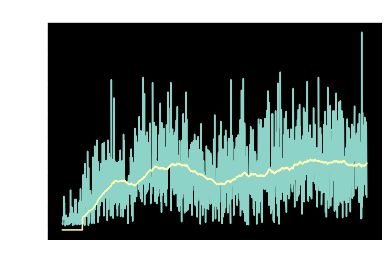

Episode 1500 
 100 episode moving avg: 113.76


In [ ]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy1, states, actions):
        return policy1(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod        
    def get_next(target1, next_states, target2):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        
        am = target1(non_final_states).max(dim=1)[1] #argmaxes!
        qs = target2(non_final_states)
        
        values[non_final_state_locations] = qs.gather(1, am.reshape(len(am),1)).reshape(len(qs)).detach()
        return values

batch_size = 256
gamma = 0.99
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update1 = 10
target_update2 = 10
target_update3 = 10
memory_size = 50000
lr = 0.001
num_episodes = 1500

em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy1 = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
policy2 = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
policy3 = DQN(em.get_screen_height(), em.get_screen_width()).to(device)

target1 = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target2 = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target3 = DQN(em.get_screen_height(), em.get_screen_width()).to(device)

target1.load_state_dict(policy1.state_dict())
target1.eval()

target2.load_state_dict(policy2.state_dict())
target2.eval()

target3.load_state_dict(policy3.state_dict())
target3.eval()


optimizer1 = optim.Adam(params=policy1.parameters(), lr=lr)
optimizer2 = optim.Adam(params=policy2.parameters(), lr=lr)
optimizer3 = optim.Adam(params=policy3.parameters(), lr=lr)


episode_durations_fd = []

#####
# steps = 0
# steps_list = []
#####

for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    for timestep in count():
        action = (agent.select_action(state, policy1)).reshape(1).cuda()
        reward = em.take_action(action)
        next_state = em.get_state()
#         print(action)
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        if memory.can_provide_sample(batch_size):
            experiences1 = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences1)

            current_q_values = QValues.get_current(policy1, states, actions)
            next_q_values = QValues.get_next(target2, next_states, target3)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer1.zero_grad()
            loss.backward()
            optimizer1.step()
            
            experiences2 = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences2)

            current_q_values = QValues.get_current(policy2, states, actions)
            next_q_values = QValues.get_next(target3, next_states, target1)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer2.zero_grad()
            loss.backward()
            optimizer2.step()

            experiences3 = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences3)

            current_q_values = QValues.get_current(policy3, states, actions)
            next_q_values = QValues.get_next(target1, next_states, target2)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer3.zero_grad()
            loss.backward()
            optimizer3.step()


        if em.done:

            #####
            # steps += timestep
            # steps_list.append(steps)
            #####

            episode_durations_fd.append(timestep)
            plot(episode_durations_fd, 100)
            break
    if episode % target_update1 == 0:
        target1.load_state_dict(policy1.state_dict())
    if episode % target_update2 == 0:
        target2.load_state_dict(policy2.state_dict())
    if episode % target_update3 == 0:
        target3.load_state_dict(policy3.state_dict())
em.close()

In [ ]:
moving_avg_fd = get_moving_average(100, episode_durations_fd)
print('best duration obtained: ',moving_avg_fd.max(),'\nat episode: ', np.argmax(moving_avg_fd))

best duration obtained:  120.29 
at episode:  1244


In [ ]:
ex_fd = t2-t1
path = '/content/drive/MyDrive/DRL/Cart/fd_scalars.pkl'
obj_fd = [episode_durations_fd,moving_avg_fd,ex_fd]
f = open(path, 'wb')
pickle.dump(obj_fd, f)
f.close()

# Complementaries:

## save notebook:

In [ ]:
# pip install dill

# import dill
# dill.dump_session('notebook_env.db')

# dill.load_session('notebook_env.db')

## save variables:

In [ ]:
# import pickle

# f = open('store.pkl', 'wb')
# pickle.dump(obj, f)
# f.close()

# f = open('store.pkl', 'rb')
# obj = pickle.load(f)
# f.close()
##############################
# import pickle

# # obj0, obj1, obj2 are created here...

# # Saving the objects:
# with open('objs.pkl', 'w') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([obj0, obj1, obj2], f)

# # Getting back the objects:
# with open('objs.pkl') as f:  # Python 3: open(..., 'rb')
#     obj0, obj1, obj2 = pickle.load(f)

### Tesnsorboard:

In [ ]:
# try:
#   %tensorflow_version 2.x
#   %load_ext tensorboard
# except:
#   pass

####################33

# %tensorboard --logdir 'logs'

## Tensorboard/Pytorch:

In [ ]:
# from torch.utils.tensorboard import SummaryWriter
# tb = SummaryWriter(log_dir = '')
# tb.add_scalar('Loss', total_loss, epoch)
# tensorboard --logdir=runs
# http://localhost:6006

## Execution Time:

In [ ]:
# import time
# t1 = time.time()
# t2 = time.time()
# print(t2-t1)